# Sampling data

The script creates a dataset of EPC certificates for Wales, applies some initial cleaning steps and splits the data into a train and test set

In [1]:
import numpy as np
import pandas as pd
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# set variables from config file
config_path = os.path.abspath('..')[:-7]

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

epc_output_fname = config['DEFAULT']['epc_output_fname']
processing_path = config['DEFAULT']['processing_path']
epc_wales_fname = config['DEFAULT']['epc_wales_fname']
epc_fname_suffix = config['DEFAULT']['epc_fname_suffix']
epc_train_fname = config['DEFAULT']['epc_train_fname']
epc_test_fname = config['DEFAULT']['epc_test_fname']

In [3]:
#Specify the import dictionary for the dates
dtype_dict = {'INSPECTION_DATE':'str','LODGEMENT_DATE':'str'}

#TODO consider specifying dtype for columns 10,11,12,44,46,73,74
epc_full = pd.read_csv(os.path.join(processing_path,epc_output_fname) + epc_fname_suffix,header = 0, 
                       delimiter = ',', dtype = dtype_dict,parse_dates = ['INSPECTION_DATE','LODGEMENT_DATE'])

/Users/soniawilliams/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,11,12,44,46,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Cleanup

### Keep certificates taken in wales and retain the feature set

In [4]:
var_list = ['LMK_KEY','region','POSTCODE','BUILDING_REFERENCE_NUMBER','CURRENT_ENERGY_RATING',
            'CURRENT_ENERGY_EFFICIENCY','PROPERTY_TYPE','BUILT_FORM','INSPECTION_DATE','LODGEMENT_DATE',
            'COUNTY','TRANSACTION_TYPE',
            'ENERGY_CONSUMPTION_CURRENT','CO2_EMISSIONS_CURRENT','CO2_EMISS_CURR_PER_FLOOR_AREA',
            'LIGHTING_COST_CURRENT','HEATING_COST_CURRENT','HOT_WATER_COST_CURRENT','TOTAL_FLOOR_AREA',
            'ENERGY_TARIFF','MAINS_GAS_FLAG','FLOOR_LEVEL','FLAT_TOP_STOREY','FLAT_STOREY_COUNT',
            'MAIN_HEATING_CONTROLS','MULTI_GLAZE_PROPORTION','GLAZED_TYPE','EXTENSION_COUNT','NUMBER_HABITABLE_ROOMS',
            'NUMBER_HEATED_ROOMS','LOW_ENERGY_LIGHTING','NUMBER_OPEN_FIREPLACES','HOTWATER_DESCRIPTION',
            'HOT_WATER_ENERGY_EFF','HOT_WATER_ENV_EFF','FLOOR_DESCRIPTION','FLOOR_ENERGY_EFF','FLOOR_ENV_EFF',
            'WINDOWS_DESCRIPTION','WINDOWS_ENERGY_EFF','WINDOWS_ENV_EFF','WALLS_DESCRIPTION','WALLS_ENERGY_EFF',
            'WALLS_ENV_EFF','SECONDHEAT_DESCRIPTION','SHEATING_ENERGY_EFF','SHEATING_ENV_EFF','ROOF_DESCRIPTION',
            'ROOF_ENERGY_EFF','ROOF_ENV_EFF','MAINHEAT_ENERGY_EFF','MAINHEAT_ENV_EFF','MAINHEATCONT_DESCRIPTION',
            'MAINHEATC_ENERGY_EFF','MAINHEATC_ENV_EFF','LIGHTING_DESCRIPTION','LIGHTING_ENERGY_EFF','LIGHTING_ENV_EFF',
            'MAIN_FUEL','HEAT_LOSS_CORRIDOOR','UNHEATED_CORRIDOR_LENGTH','FLOOR_HEIGHT','SOLAR_WATER_HEATING_FLAG',
            'MECHANICAL_VENTILATION']

region_list = ['Isle of Anglesey','Blaenau Gwent','Bridgend','Caerphilly','Cardiff','Carmarthenshire',
'Ceredigion','Conwy','Debighshire','Flintshire','Gwynedd','Merthyr Tydfil','Monmouthshire',
'Neath Port Talbot','Newport','Powys','Pembrokeshire','Rhondda Cynon Taf','Swansea','Torfaen',
'Vale of Glamorgan','Wrexham']

epc_wales = epc_full.loc[epc_full['region'].isin(region_list),var_list]

In [5]:
# remove records with dodgy postcodes, these originate form the unknown_certificates file
epc_wales = epc_wales[epc_wales['POSTCODE'] != 'XX0 0XX']

In [6]:
len(epc_wales)

805772

In [7]:
# show split across bands
epc_wales['CURRENT_ENERGY_RATING'].value_counts()

D           311744
C           193012
E           166845
F            55780
B            55131
G            21995
A             1251
INVALID!        14
Name: CURRENT_ENERGY_RATING, dtype: int64

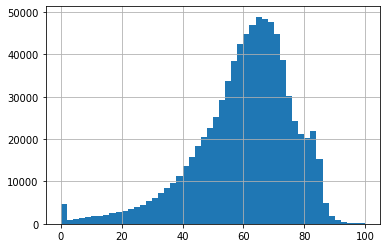

In [8]:
epc_wales['CURRENT_ENERGY_EFFICIENCY'].hist(bins=50,range=(0,100))
plt.show()

In [9]:
# Shouldn't be above 100 gets capped later in the process
epc_wales['CURRENT_ENERGY_EFFICIENCY'].max()

184

In [11]:
# Capping for purposes of plotting distributions
epc_capped = epc_wales[epc_wales.CURRENT_ENERGY_EFFICIENCY <= 100]

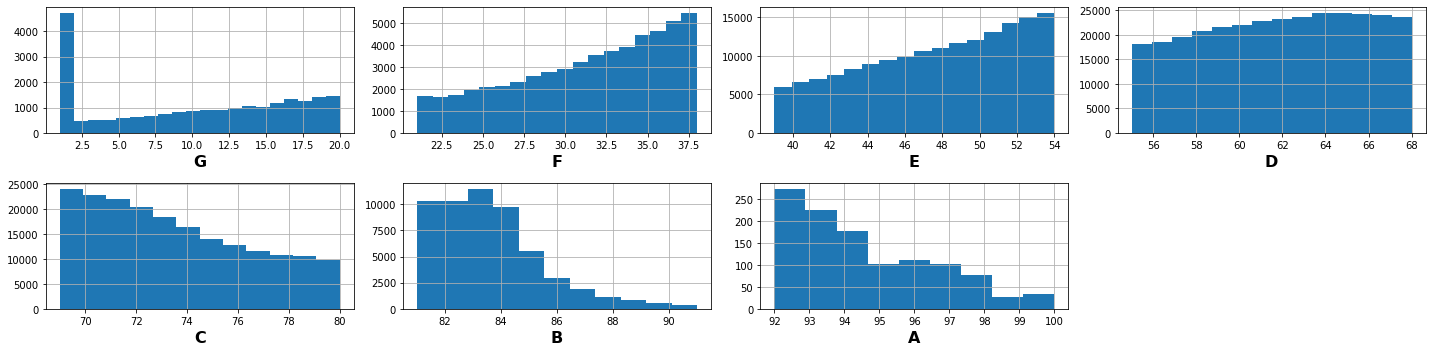

In [12]:
# plot distribution per band
plt.figure(figsize=(20,5))

epc_bands_G = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'G']
plt.subplot(241)
bins_G = len(epc_bands_G['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_G['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_G)
plt.xlabel('G',fontsize=16, weight='bold')

epc_bands_F = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'F']
plt.subplot(242)
bins_F = len(epc_bands_F['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_F['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_F)
plt.xlabel('F',fontsize=16, weight='bold')

epc_bands_E = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'E']
plt.subplot(243)
bins_E = len(epc_bands_E['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_E['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_E)
plt.xlabel('E',fontsize=16, weight='bold')

epc_bands_D = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'D']
plt.subplot(244)
bins_D = len(epc_bands_D['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_D['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_D)
plt.xlabel('D',fontsize=16, weight='bold')

epc_bands_C = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'C']
plt.subplot(245)
bins_C = len(epc_bands_C['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_C['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_C)
plt.xlabel('C',fontsize=16, weight='bold')

epc_bands_B = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'B']
plt.subplot(246)
bins_B = len(epc_bands_B['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_B['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_B)
plt.xlabel('B',fontsize=16, weight='bold')

epc_bands_A = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'A']
plt.subplot(247)
bins_A = len(epc_bands_A['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_A['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_A)
plt.xlabel('A',fontsize=16, weight='bold')

plt.tight_layout()

### Imputing missing values

For values which do not change often over time such as BUILT_FORM (detached, terraced etc), it's safe to use the data from previous certificates where available to fill the missing values in more recent certificates.

In [13]:
len(epc_wales)

805772

In [14]:
# It's only necessary to do this for properties with more than one certificate
epc_wales_grouped = epc_wales.groupby(['BUILDING_REFERENCE_NUMBER'], as_index=False)['INSPECTION_DATE'].count()
epc_wales_grouped_2plus = epc_wales_grouped[epc_wales_grouped['INSPECTION_DATE'] > 1]
epc_wales_2plus = epc_wales.merge(epc_wales_grouped_2plus[['BUILDING_REFERENCE_NUMBER']], on = 'BUILDING_REFERENCE_NUMBER', how = 'inner')

In [15]:
# note this takes a while
fill_columns = ['BUILT_FORM','MAINS_GAS_FLAG','FLOOR_LEVEL','NUMBER_HABITABLE_ROOMS','FLOOR_DESCRIPTION',
                'ROOF_DESCRIPTION','HEAT_LOSS_CORRIDOOR','WALLS_DESCRIPTION','FLOOR_HEIGHT']

for c in fill_columns:
    print(c)
    epc_wales_2plus[c] = epc_wales_2plus.groupby(['BUILDING_REFERENCE_NUMBER'], sort=False)[c].apply(lambda x: x.ffill())

BUILT_FORM
MAINS_GAS_FLAG
FLOOR_LEVEL
NUMBER_HABITABLE_ROOMS
FLOOR_DESCRIPTION
ROOF_DESCRIPTION
HEAT_LOSS_CORRIDOOR
WALLS_DESCRIPTION
FLOOR_HEIGHT


In [16]:
epc_wales_grouped_1 = epc_wales_grouped[epc_wales_grouped['INSPECTION_DATE'] == 1]
epc_wales_1 = epc_wales.merge(epc_wales_grouped_1[['BUILDING_REFERENCE_NUMBER']], on = 'BUILDING_REFERENCE_NUMBER', how = 'inner')

In [17]:
# merging filled data for buildings with more than one certificate with data for buildings with only one certificate
epc_filled = pd.concat([epc_wales_1,epc_wales_2plus])

In [18]:
# checking length of filled data
len(epc_filled)

805772

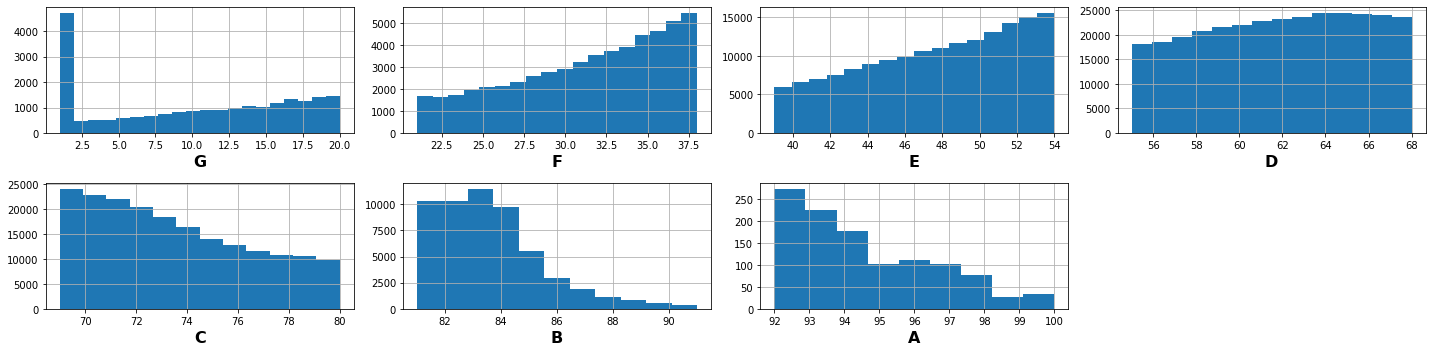

In [19]:
# plotting distribution of filled data for each band. Shouldn't have changed
epc_capped = epc_filled[epc_filled.CURRENT_ENERGY_EFFICIENCY <= 100]

# plot distribution per band
plt.figure(figsize=(20,5))

epc_bands_G = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'G']
plt.subplot(241)
bins_G = len(epc_bands_G['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_G['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_G)
plt.xlabel('G',fontsize=16, weight='bold')

epc_bands_F = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'F']
plt.subplot(242)
bins_F = len(epc_bands_F['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_F['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_F)
plt.xlabel('F',fontsize=16, weight='bold')

epc_bands_E = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'E']
plt.subplot(243)
bins_E = len(epc_bands_E['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_E['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_E)
plt.xlabel('E',fontsize=16, weight='bold')

epc_bands_D = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'D']
plt.subplot(244)
bins_D = len(epc_bands_D['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_D['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_D)
plt.xlabel('D',fontsize=16, weight='bold')

epc_bands_C = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'C']
plt.subplot(245)
bins_C = len(epc_bands_C['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_C['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_C)
plt.xlabel('C',fontsize=16, weight='bold')

epc_bands_B = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'B']
plt.subplot(246)
bins_B = len(epc_bands_B['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_B['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_B)
plt.xlabel('B',fontsize=16, weight='bold')

epc_bands_A = epc_capped[epc_capped.CURRENT_ENERGY_RATING == 'A']
plt.subplot(247)
bins_A = len(epc_bands_A['CURRENT_ENERGY_EFFICIENCY'].unique())
epc_bands_A['CURRENT_ENERGY_EFFICIENCY'].hist(bins=bins_A)
plt.xlabel('A',fontsize=16, weight='bold')

plt.tight_layout()

### Deduping by taking latest record

Some properties have multiple EPC, we only want to keep one per inspection data

In [20]:
len(epc_filled[epc_filled.duplicated(subset=['BUILDING_REFERENCE_NUMBER','INSPECTION_DATE'])])

15013

In [21]:
# First take just the latest lodegment date
epc_filled.sort_values(by = ['BUILDING_REFERENCE_NUMBER','INSPECTION_DATE','LODGEMENT_DATE'],inplace=True)
epc_filled.drop_duplicates(subset=(['BUILDING_REFERENCE_NUMBER','INSPECTION_DATE']),keep='last',inplace=True)

In [22]:
len(epc_filled[epc_filled.duplicated(subset=['BUILDING_REFERENCE_NUMBER','INSPECTION_DATE'])])

0

### Split in to train and test - 80% split

Splitting the train and test data before any further manipulation

In [23]:
epc_filled = shuffle(epc_filled)
epc_filled.reset_index(drop=True)
epc_train, epc_test = train_test_split(epc_filled, test_size = 0.2, random_state = 1234)

In [24]:
#Check the distribution of the categorical target
print(epc_filled['CURRENT_ENERGY_RATING'].value_counts(normalize = True))
print(epc_train['CURRENT_ENERGY_RATING'].value_counts(normalize = True))
print(epc_test['CURRENT_ENERGY_RATING'].value_counts(normalize = True))

#Check the stats of the numerc target
print(epc_filled['CURRENT_ENERGY_EFFICIENCY'].describe())
print(epc_train['CURRENT_ENERGY_EFFICIENCY'].describe())
print(epc_test['CURRENT_ENERGY_EFFICIENCY'].describe())

D           0.387016
C           0.240932
E           0.206412
B           0.068702
F           0.068676
G           0.026695
A           0.001552
INVALID!    0.000016
Name: CURRENT_ENERGY_RATING, dtype: float64
D           0.387340
C           0.240962
E           0.206100
B           0.068757
F           0.068684
G           0.026650
A           0.001495
INVALID!    0.000013
Name: CURRENT_ENERGY_RATING, dtype: float64
D           0.385718
C           0.240813
E           0.207661
F           0.068643
B           0.068485
G           0.026873
A           0.001777
INVALID!    0.000032
Name: CURRENT_ENERGY_RATING, dtype: float64
count    790759.000000
mean         59.810562
std          15.916417
min           0.000000
25%          52.000000
50%          62.000000
75%          71.000000
max         184.000000
Name: CURRENT_ENERGY_EFFICIENCY, dtype: float64
count    632607.000000
mean         59.817269
std          15.909328
min           0.000000
25%          52.000000
50%          62.0

In [25]:
len(epc_train[epc_train.isnull()])

632607

### Clean up

In [26]:
# replace 'NO DATA!', 'not defined' and 'not recored' with null
epc_train = epc_train.replace(['NO DATA!','NODATA!'],np.nan)
epc_train = epc_train.replace(['not recorded','not defined','unknown','Unknown','Not defined','Not recorded'],np.nan)
epc_train = epc_train.replace(['N/A','n/a'],np.nan)
# replace any values starting sap as these are the column headers not real data
epc_train = epc_train.replace([r'^SAP.*',r'^sap.*'],np.nan,regex=True)
# replace '+ Chr(13) +' as it's meaningless
epc_train = epc_train.replace([r"\+ Chr\(13\) \+",r"\+ chr\(13\) \+"],'+', regex=True)
epc_train = epc_train.replace([r"\+ Chr\(13\) \+",r"\+ chr\(13\) \+"],'+', regex=True)

In [27]:
# replace 'NO DATA!', 'not defined' and 'not recored' with null
epc_test = epc_test.replace(['NO DATA!','NODATA!'],np.nan)
epc_test = epc_test.replace(['not recorded','not defined','unknown','Unknown','Not defined','Not recorded'],np.nan)
epc_test = epc_test.replace(['N/A','n/a'],np.nan)
# replace any values starting sap as these are the column headers not real data
epc_test = epc_test.replace([r'^SAP.*',r'^sap.*'],np.nan,regex=True)
# replace '+ Chr(13) +' as it's meaningless
epc_test = epc_test.replace([r"\+ Chr\(13\) \+",r"\+ chr\(13\) \+"],'+', regex=True)

In [28]:
# replacing values in columns which are actually just the column header
replacement_dict = {'HOTWATER_DESCRIPTION':{r'^Hot-Water$':np.nan},'FLOOR_DESCRIPTION':{r'^Floor$':np.nan},
'WALLS_DESCRIPTION':{r'^Wall$':np.nan},'WINDOWS_DESCRIPTION':{r'^Window$':np.nan},'ROOF_DESCRIPTION':{r'^Roof$':np.nan},
'MAIN_HEATING_CONTROLS':{r'^Main-Heating-Controls$':np.nan},'SECONDHEAT_DESCRIPTION':{r'^Secondary-Heating$':np.nan},
'LIGHTING_DESCRIPTION':{r'^Lighting$':np.nan},'MAINHEATCONT_DESCRIPTION':{r'^Main-Heating-Controls$':np.nan}}

epc_train = epc_train.replace(replacement_dict,regex=True)
epc_test = epc_test.replace(replacement_dict,regex=True)

### Export Data

In [ ]:
epc_train.to_csv(os.path.join(processing_path,epc_train_fname),index = False)
epc_test.to_csv(os.path.join(processing_path,epc_test_fname),index = False)
epc_wales.to_csv(processing_path + epc_wales_fname, index=False)